# Selección de portafolio de inversión óptimo 

<span style="color:gray"> Proyecto Módulo 2 </span>
* Joaquín Uriel Ramírez
* Daniel Orozco

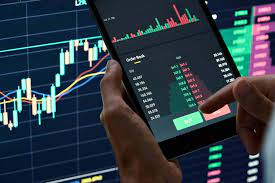

___
## Objetivo general
> #### Determinar la cantidad a invertir en cada una de un conjunto de acciones bursátiles con el propósito de maximizar ganancias.

### Objetivos específicos

> * Identificar activos para el portafolio.
> *Calcular los retornos y volatilidad de los activos en base a datos históricos.
> *Programar el problema de optimización.
> *Resolver mediante Montecarlo.

In [25]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
from datetime import datetime
import scipy.stats as stats
import scipy as sp
import scipy.optimize as scopt
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.covariance as skcov
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)

In [26]:
#función para obtener precios al cierre de cada día
def getClose(name, start, end) :
    return web.DataReader(name, "yahoo", start, end)["Adj Close"]

In [27]:
#activos a analizar
assets = ['AAPL','AMZN','MSFT','KO']
closes=getClose(assets, '2018-01-01', '2022-11-02')
closes

Symbols,AAPL,AMZN,MSFT,KO
Date,,,,
2018-01-02,41.018429,59.450500,81.168495,39.119373
2018-01-03,41.011288,60.209999,81.546234,39.033474
2018-01-04,41.201775,60.479500,82.263962,39.583244
2018-01-05,41.670872,61.457001,83.283882,39.574657
2018-01-08,41.516102,62.343498,83.368866,39.514526
...,...,...,...,...
2022-10-27,144.800003,110.959999,226.750000,59.529999
2022-10-28,155.740005,103.410004,235.869995,60.759998
2022-10-31,153.339996,102.440002,232.130005,59.849998


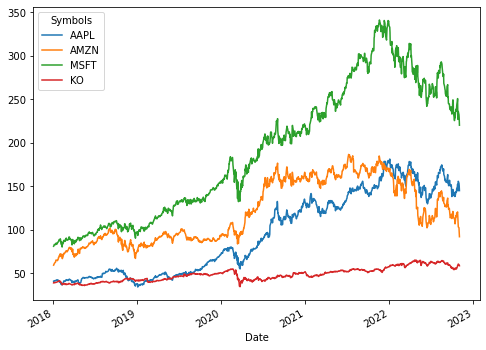

In [28]:
#gráfico de precios
closes.plot(figsize=(8,6));

## Formulación del riesgo de un portafolio

In [29]:
#cálculo de retornos diarios
def calc_daily_returns(closes):
    return np.log(closes/closes.shift(1))[1:]

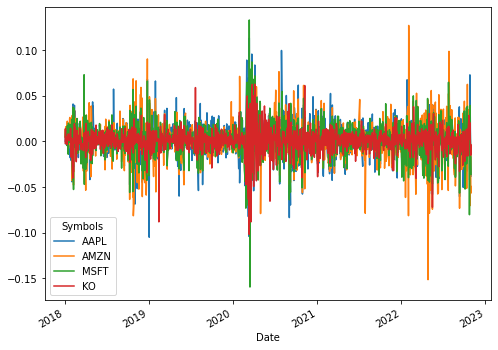

In [30]:
gráfico de retornos diarios
daily_returns=calc_daily_returns(closes)
daily_returns.plot(figsize=(8,6));

In [31]:
mean_daily_returns = pd.DataFrame(daily_returns.mean(),columns=['Mean'],index=daily_returns.columns)
mean_daily_returns

,Mean
Symbols,
AAPL,0.001037
AMZN,0.000360
MSFT,0.000819
KO,0.000335


In [32]:
cov_matrix = daily_returns.cov()
cov_matrix

Symbols,AAPL,AMZN,MSFT,KO
Symbols,,,,
AAPL,0.000441,0.000302,0.000315,0.000122
AMZN,0.000302,0.000499,0.000309,0.000076
MSFT,0.000315,0.000309,0.000379,0.000123
KO,0.000122,0.000076,0.000123,0.000190


In [33]:
robust_cov_matrix= pd.DataFrame(skcov.ShrunkCovariance().fit(daily_returns).covariance_,columns=daily_returns.columns,index=daily_returns.columns)
robust_cov_matrix

Symbols,AAPL,AMZN,MSFT,KO
Symbols,,,,
AAPL,0.000434,0.000272,0.000283,0.000110
AMZN,0.000272,0.000487,0.000278,0.000068
MSFT,0.000283,0.000278,0.000378,0.000111
KO,0.000110,0.000068,0.000111,0.000208


## Optimización de portafolios

In [40]:
num_portfolios = 25000
r=0.0009 #tasa libre de riesgo
results = np.zeros((3+len(assets),num_portfolios))
for i in range(num_portfolios):
    #Pesos
    weights = np.array(np.random.random(4))
    weights /= np.sum(weights)
 
    #Rendimiento y volatilidad
    portfolio_return = mean_daily_returns.T.dot(weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(robust_cov_matrix, weights))) * np.sqrt(252)
 
    #Resultados
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    #Sharpe
    results[2,i] = (results[0,i]-r) / results[1,i]
    #Iteraciones
    for j in range(len(weights)):
        results[j+3,i] = weights[j]

In [41]:
results_frame = pd.DataFrame(results.T,columns=(['Rendimiento','SD','Sharpe']+list(daily_returns.columns)))

In [42]:
#Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['Sharpe'].idxmax()]
#Menor SD
min_vol_port = results_frame.iloc[results_frame['SD'].idxmin()]

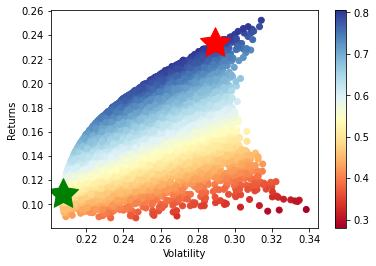

In [43]:
plt.scatter(results_frame.SD,results_frame.Rendimiento,c=results_frame.Sharpe,cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()
#Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=1000);
#Menor SD
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=1000);

In [44]:
pd.DataFrame(max_sharpe_port)

,8896
Rendimiento,0.233619
SD,0.289121
Sharpe,0.804917
AAPL,0.676613
AMZN,0.000301
MSFT,0.242085
KO,0.081001


In [45]:
pd.DataFrame(min_vol_port)

,19034
Rendimiento,0.108526
SD,0.207351
Sharpe,0.519052
AAPL,0.081969
AMZN,0.172019
MSFT,0.070426
KO,0.675586
